In [48]:
%matplotlib inline
import os
import shutil
import subprocess as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu
import platform
if 'window' in platform.platform().lower():
    ppp = 'pest++'
    pref = ''
else:
    ppp = './pestpp'
    pref = './'

In [49]:
base_dir = os.path.join("..","..","models","Freyberg","Freyberg_K_and_R")
[shutil.copy(os.path.join(base_dir,f),f) for f in os.listdir(base_dir)]
if not os.path.exists('base_resp_dir'):
    os.mkdir('base_resp_dir')
[shutil.copy2(os.path.join(base_dir,cf),os.path.join('base_resp_dir',cf)) for cf in os.listdir(base_dir)];


## First read in the PST file and find what are the starting values for K and R

In [50]:
inpst = pyemu.Pst('freyberg.pst')
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch1,rch1,fixed,factor,0.000110,0.000079,0.000155,rch,1.0,0.0,1
rch2,rch2,fixed,factor,0.000094,0.000079,0.000155,rch,1.0,0.0,1
hk1,hk1,log,factor,8.000000,1.250000,80.000000,hk,1.0,0.0,1


In [51]:
inpst.parameter_data.loc['rch1','partrans']= 'log'
inpst.write('freyberg.pst')

In [52]:
os.system('{0} freyberg.pst'.format(ppp))

0

In [53]:
inpst.phi_components

{'flux_cal': 0.0,
 'flux_fore': 0.0,
 'head_cal': 98.1802598698,
 'head_fore': 0.0,
 'travel_fore': 0.0}

## Now make a CSV file of values to evaluate

In [54]:
nsamples = 20
hk_start = inpst.parameter_data.loc[inpst.parameter_data.parnme=='hk1'].parval1.values[0]
hk_lower=3
hk_upper = 12
rch1_start = inpst.parameter_data.loc[inpst.parameter_data.parnme=='rch1'].parval1.values[0]
rch1_lower= 0.0001
rch1_upper= 0.00017
rch2_start = inpst.parameter_data.loc[inpst.parameter_data.parnme=='rch2'].parval1.values[0]


In [55]:
hk_values = np.linspace(hk_lower,hk_upper,nsamples)
rch1_values = np.linspace(rch1_lower,rch1_upper,nsamples)
c = 0
with open("grid.csv",'w') as f:
    f.write("run_id,hk1,rch1,rch2\n")
    for v1 in hk_values:
        for v2 in rch1_values:
            f.write("{0:d},{1:15.6E},{2:15.6E},{3:15.6E}\n".format(c,v1,v2,rch2_start))
            c += 1
shutil.copy2('grid.csv','base_resp_dir')

'base_resp_dir\\grid.csv'

In [56]:
def resp_plot():
    df_in = pd.read_csv("grid.csv")
    df_out = pd.read_csv("sweep_out.csv", na_values='')
    resp_surf = np.zeros((nsamples,nsamples))
    c = 0
    for i,v1 in enumerate(hk_values):
        for j,v2 in enumerate(rch1_values):
            resp_surf[j,i] = df_out.loc[c,"phi"]
            c += 1
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(111)
    X,Y = np.meshgrid(hk_values,rch1_values)
    # knock out extreme high values
    resp_surf = np.flipud(resp_surf)
    resp_surf[resp_surf>np.nanpercentile(resp_surf,75)] = np.nan
    resp_surf = np.ma.masked_where(np.isnan(resp_surf),resp_surf)
    p = ax.pcolor(X,Y,resp_surf,alpha=0.5,cmap="spectral")
    plt.colorbar(p)
    c = ax.contour(X,Y,resp_surf,levels=np.linspace(np.min(resp_surf),np.max(resp_surf),6),colors='k')
    plt.clabel(c)
    ax.set_xlim(hk_values.min(),hk_values.max())
    ax.set_ylim(rch1_values.min(),rch1_values.max())
    ax.set_xlabel("hk1 ($\\frac{L}{T}$)")
    ax.set_ylabel("rch1 ($L$)")

In [57]:
pyemu.utils.start_slaves('base_resp_dir',"{0}sweep".format(pref),"freyberg.pst",20,slave_root='.',port=4004,master_dir='.')

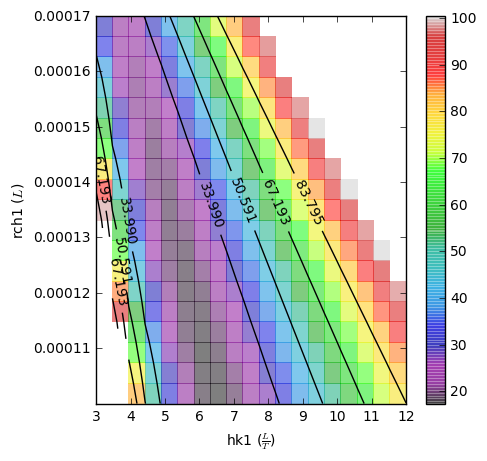

In [58]:
resp_plot()

### We can look at the final parameter values and their correlation

In [59]:
pars = pd.read_csv('freyberg.ipar')
pars

,iteration,rch1,rch2,hk1
0,0,0.00011,0.000094,8


In [60]:
sc = pyemu.Schur('freyberg.jcb')
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,rch1,hk1
rch1,1461.370383,-1315.967846
hk1,-1315.967846,1194.881974


In [61]:
R = covar.to_pearson()
R.df()

,rch1,hk1
rch1,1.00000,-0.99587
hk1,-0.99587,1.00000


# What if we also have a calibration flux observation?

We can set this up by simply assigning non-zero weight to the observation called `rivflux_cal`

We've already read in the PST file, now we can change just that one value and write out a new PST file.

In [62]:
# using the pandas set_value method
pst0p1 = pyemu.Pst('freyberg.pst')
pst0p1.observation_data.loc['rivflux_cal','weight']=0.1
pst0p1.write('freyberg_w_flux0p1.pst')
shutil.copy2('freyberg_w_flux0p1.pst',os.path.join('base_resp_dir','freyberg_w_flux0p1.pst'))

'base_resp_dir\\freyberg_w_flux0p1.pst'

In [63]:
os.system('{0} freyberg_w_flux0p1.pst'.format(ppp))

0

In [64]:
pst0p1.phi_components

{'flux_cal': 8106.769413759999,
 'flux_fore': 0.0,
 'head_cal': 98.1802598698,
 'head_fore': 0.0,
 'travel_fore': 0.0}

In [65]:
pyemu.utils.start_slaves('base_resp_dir',"{0}sweep".format(pref),"freyberg_w_flux0p1.pst",20,slave_root='.',port=4004,master_dir='.')

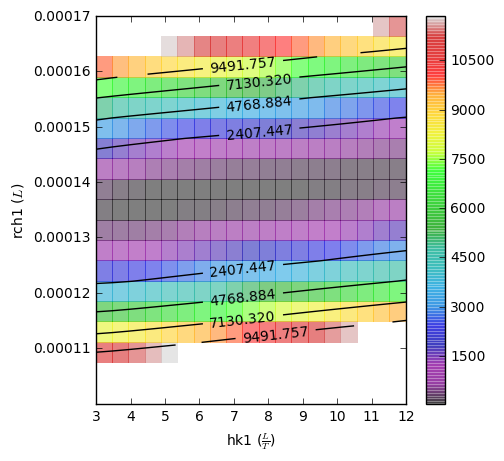

In [66]:
resp_plot()

### Now let's run PEST++ and see what we get for an estimate of the parameters
 * set NOPTMAX=-1
 * run PEST++

In [67]:
pst0p1.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch1,rch1,log,factor,0.000110,0.000079,0.000155,rch,1.0,0.0,1
rch2,rch2,fixed,factor,0.000094,0.000079,0.000155,rch,1.0,0.0,1
hk1,hk1,log,factor,8.000000,1.250000,80.000000,hk,1.0,0.0,1


In [68]:
pst0p1.control_data.noptmax=-1
pst0p1.parameter_data.loc['rch1','partrans']= 'log'
pst0p1.write('freyberg_w_flux0p1.pst')
shutil.copy2('freyberg_w_flux0p1.pst',os.path.join('base_resp_dir','freyberg_w_flux0p1.pst'))

'base_resp_dir\\freyberg_w_flux0p1.pst'

In [69]:
os.system('{0} freyberg_w_flux0p1.pst'.format(ppp))

0

### We can look at the final parameter values and their correlation

In [70]:
pars = pd.read_csv('freyberg_w_flux0p1.ipar')
pars

,iteration,rch1,rch2,hk1
0,0,0.00011,0.000094,8


In [71]:
sc = pyemu.Schur('freyberg_w_flux0p1.jcb')
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,rch1,hk1
rch1,1.004258e+06,46947.272660
hk1,4.694727e+04,2692.373346


In [72]:
R = covar.to_pearson()
R.df()

,rch1,hk1
rch1,1.000000,0.902859
hk1,0.902859,1.000000


In [73]:
# using the pandas set_value method
pst0p001=pyemu.Pst('freyberg.pst')
pst0p001.observation_data.loc['rivflux_cal','weight']=0.001
pst0p001.write('freyberg_w_flux0p001.pst')
shutil.copy2('freyberg_w_flux0p001.pst',os.path.join('base_resp_dir','freyberg_w_flux0p001.pst'))

'base_resp_dir\\freyberg_w_flux0p001.pst'

In [74]:
os.system('{0} freyberg_w_flux0p001.pst'.format(ppp))

0

In [75]:
pst0p001.phi_components

{'flux_cal': 0.8106769413759999,
 'flux_fore': 0.0,
 'head_cal': 98.1802598698,
 'head_fore': 0.0,
 'travel_fore': 0.0}

In [76]:
pyemu.utils.start_slaves('base_resp_dir',"{0}sweep".format(pref),"freyberg_w_flux0p001.pst",20,slave_root='.',port=4004,master_dir='.')

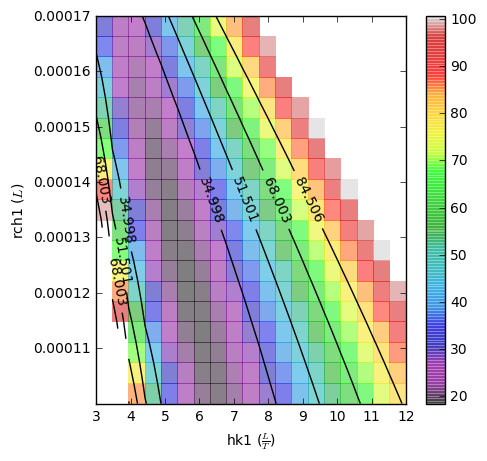

In [77]:
resp_plot()

In [78]:
pst0p001.control_data.noptmax=-1
pst0p001.write('freyberg_w_flux0p001.pst')

In [79]:
os.system('{0} freyberg_w_flux0p001.pst'.format(ppp))

0

In [80]:
pars = pd.read_csv('freyberg_w_flux0p001.ipar')
pars

,iteration,rch1,rch2,hk1
0,0,0.00011,0.000094,8


In [81]:
sc = pyemu.Schur('freyberg_w_flux0p001.jcb')
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,rch1,hk1
rch1,686.478674,-504.061408
hk1,-504.061408,448.757038


In [82]:
R = covar.to_pearson()
R.df()

,rch1,hk1
rch1,1.000000,-0.908164
hk1,-0.908164,1.000000


In [83]:
# using the pandas set_value method
pst0p01=pyemu.Pst('freyberg.pst')
pst0p01.observation_data.loc['rivflux_cal','weight']=0.01
pst0p01.write('freyberg_w_flux0p01.pst')
shutil.copy2('freyberg_w_flux0p01.pst',os.path.join('base_resp_dir','freyberg_w_flux0p01.pst'))

'base_resp_dir\\freyberg_w_flux0p01.pst'

In [84]:
os.system('{0} freyberg_w_flux0p01.pst'.format(ppp))

0

In [85]:
pst0p01.phi_components

{'flux_cal': 81.0676941376,
 'flux_fore': 0.0,
 'head_cal': 98.1802598698,
 'head_fore': 0.0,
 'travel_fore': 0.0}

In [86]:
pyemu.utils.start_slaves('base_resp_dir',"{0}sweep".format(pref),"freyberg_w_flux0p01.pst",20,slave_root='.',port=4004,master_dir='.')

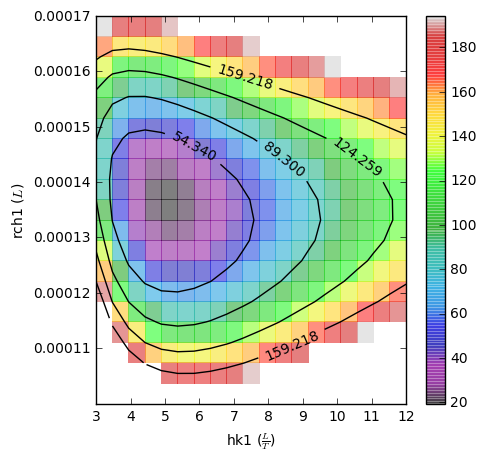

In [87]:
resp_plot()

In [88]:
pst0p01.control_data.noptmax=-1
pst0p01.write('freyberg_w_flux0p01.pst')
shutil.copy2('freyberg_w_flux0p01.pst',os.path.join('base_resp_dir','freyberg_w_flux0p01.pst'))

'base_resp_dir\\freyberg_w_flux0p01.pst'

In [89]:
os.system('{0} freyberg_w_flux0p01.pst'.format(ppp))

0

In [90]:
pars = pd.read_csv('freyberg_w_flux0p01.ipar')
pars

,iteration,rch1,rch2,hk1
0,0,0.00011,0.000094,8


In [91]:
sc = pyemu.Schur('freyberg_w_flux0p01.jcb')
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,rch1,hk1
rch1,10622.828927,-34.246220
hk1,-34.246220,470.971061


In [92]:
R = covar.to_pearson()
R.df()

,rch1,hk1
rch1,1.000000,-0.015311
hk1,-0.015311,1.000000


In [93]:
pst0p01.control_data.noptmax=15
pst0p01.write('freyberg_w_flux0p01.pst')

In [94]:
os.system('{0} freyberg_w_flux0p01.pst'.format(ppp))

0

In [95]:
sc = pyemu.Schur('freyberg_w_flux0p01.jcb')
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,rch1,hk1
rch1,16514.982071,-1017.190672
hk1,-1017.190672,1241.153388


In [96]:
R = covar.to_pearson()
R.df()

,rch1,hk1
rch1,1.000000,-0.224673
hk1,-0.224673,1.000000
